In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
# from tqdm import

In [2]:
connectivity_min, connectivity_max = 0.1,65
random_input_span = (9.5,13.5)

total_time = 100

neuron_model = 'Rotational'
model_folder_name = neuron_model+'_ensembles'

# Capture related ensembles

In [3]:
def list_folders_in_path(path):
    return [ name for name in os.listdir( path ) if os.path.isdir( os.path.join(path, name) ) ]

In [4]:
num_neurons = 10000
target_networks_name = 'N{}_T{}_I{}_{}'.format(num_neurons,total_time,random_input_span[0],random_input_span[1])
target_path = os.path.join(model_folder_name,target_networks_name)
all_g_folders = list_folders_in_path(target_path)
desired_g_folders = all_g_folders

# delay_folder_name = 'd_{}'.format(delay)

In [5]:
sigma_glossary_dict = {}
amin_saman_param_glossary_dict = {}
field_period_glossary_dict = {}

In [6]:
for g_folder in desired_g_folders:
    available_d_folders = list_folders_in_path(os.path.join(target_path,g_folder))

    g = float( g_folder.split('_')[1] ) #folder names are g_# d_#
    
    sigma_glossary_dict[g] = {}
    amin_saman_param_glossary_dict[g] = {}
    field_period_glossary_dict[g] = {}
    
    for d_folder in available_d_folders:
        delay = float( d_folder.split('_')[1] ) #folder names are d_#
        
        g_d_path = os.path.join(target_path, g_folder, d_folder)

        try:
            g_ensembles_list = list_folders_in_path(g_d_path)
            

            sigma_glossary_dict[g].update( {delay:[]} )
            amin_saman_param_glossary_dict[g].update( {delay:[]} )
            field_period_glossary_dict[g].update( {delay:[]} )
        except: #if the given connectivity and delay has not been measured even once
            continue

        for ensemble_num in g_ensembles_list:
            ensemble_path = os.path.join(g_d_path, ensemble_num)
            with open( os.path.join(ensemble_path,'sigma.txt') ) as file:
                sigma = float( file.readline() )
                sigma_glossary_dict[g][delay].append( sigma )

            with open( os.path.join(ensemble_path,'field_period.txt') ) as file:
                field_period = float( file.readline() )
                field_period_glossary_dict[g][delay].append( field_period )                

            if neuron_model == 'Rotational': #if not does not exist
                with open( os.path.join(ensemble_path,'amin_saman_param.txt') ) as file:
                    amin_saman_param = float( file.readline() )        
                    amin_saman_param_glossary_dict[g][delay].append( amin_saman_param )        


        sigma_glossary_dict[g][delay] = np.mean(sigma_glossary_dict[g][delay])
        amin_saman_param_glossary_dict[g][delay] = np.mean(amin_saman_param_glossary_dict[g][delay])
        field_period_glossary_dict[g][delay] = np.mean(field_period_glossary_dict[g][delay])


# Sigma dataframe

In [7]:
sigma_table = pd.DataFrame.from_dict(sigma_glossary_dict)
sigma_table.index.name = 'delay'
sigma_table.columns.name = 'connectivity'
sigma_table

connectivity,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
delay,,,,,,,,,,
0.05,0.169001,0.168394,0.169606,0.171655,0.177948,0.181028,0.175677,0.174586,0.174218,0.175543
0.07,0.199110,0.201393,0.207225,0.206750,0.206012,0.207342,0.215005,0.251736,0.284099,0.294926
0.09,0.214606,0.217746,0.223726,0.228030,0.239375,0.333396,0.357310,0.367228,0.371662,0.372998
0.11,0.217828,0.225720,0.230932,0.319528,0.391410,0.410163,0.416975,0.418545,0.419443,0.418680
0.13,0.225268,0.234536,0.359490,0.430369,0.446288,0.454548,0.457661,0.459325,0.456766,0.454565
0.15,0.244964,0.260693,0.449636,0.479195,0.487466,0.492805,0.510167,0.503854,0.498684,0.493595
0.17,0.229323,0.404604,0.486599,0.499275,0.514720,0.518084,0.518276,0.518930,0.517905,0.530177
0.19,0.238980,0.486332,0.525774,0.537684,0.542181,0.543121,0.544403,0.549463,1.044133,1.034655
0.21,0.248827,0.518273,0.549782,0.557239,0.562558,0.564254,0.570745,1.064438,1.055917,1.013367


Text(0.5, 1, 'Sigma as an Order parameter')

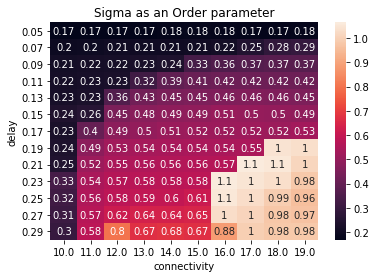

In [8]:
ax_sigma = sns.heatmap(sigma_table, annot=True)
ax_sigma.set_title('Sigma as an Order parameter')

# Field period dataframe

In [9]:
field_period_table = pd.DataFrame.from_dict(field_period_glossary_dict)
field_period_table.index.name = 'delay'
field_period_table.columns.name = 'connectivity'
field_period_table

connectivity,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
delay,,,,,,,,,,
0.05,0.110,0.155,0.180,0.145,0.170,0.150,0.115,0.140,0.100,0.175
0.07,0.060,0.165,0.195,0.130,0.165,0.160,0.220,0.180,0.185,0.200
0.09,0.225,0.215,0.165,0.205,0.210,0.215,0.225,0.220,0.235,0.220
0.11,0.210,0.240,0.195,0.240,0.260,0.260,0.240,0.250,0.250,0.285
0.13,0.220,0.265,0.265,0.275,0.285,0.275,0.300,0.280,0.275,0.375
0.15,0.205,0.295,0.295,0.315,0.345,0.300,0.335,0.305,0.385,0.380
0.17,0.295,0.320,0.335,0.350,0.320,0.330,0.385,0.330,0.335,0.430
0.19,0.280,0.345,0.345,0.380,0.390,0.460,0.430,0.360,0.405,0.400
0.21,0.385,0.385,0.400,0.405,0.430,0.385,0.380,0.865,0.875,1.325


Text(0.5, 1, 'Field period time')

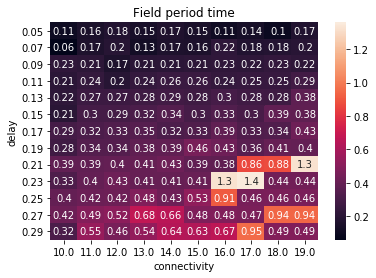

In [10]:
ax_field_period = sns.heatmap(field_period_table, annot=True)
ax_field_period.set_title('Field period time')

# Amin Saman Parameter

Text(0.5, 1, 'AminSaman as an Order parameter ')

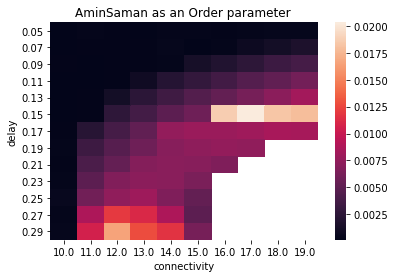

In [11]:
amin_saman_param_table = pd.DataFrame.from_dict(amin_saman_param_glossary_dict)
amin_saman_param_table.index.name = 'delay'
amin_saman_param_table.columns.name = 'connectivity'
ax_field_period = sns.heatmap(amin_saman_param_table)
ax_field_period.set_title('AminSaman as an Order parameter ')